# Airbnb San Francisco data

#### People travel for work, for pleasure and for some it is just a way of life. San Francisco has a lot to offer to travellers of any kind. The city is known for its diverse culture, fantastic scenery, unusual climate and great food. One basic need for any kind of traveller is accomodation, where he is relaxes while on the tour. These days, many people prefer listings in Airbnb compared to luxurious hotels, either based on their budget or for a family home feel or based on the size of the group. In this work, we are attempting to do an analysis on Airbnb San Francisco data to understand how a traveller makes a decision on his accomodation choice. We would like to look into 
#### - We want to see why some accomodations have high ratings compared to the rest?
#### - Why are some accomodations occupied more compared to the rest?
#### - Can we send recommendations to the hosts/owners with less ratings and occupancy for improvement?
#### - Which locality and what kind of accomodation is a traveller more like to stay at?
#### - Can we send recommendations to the travellers based on price range, description, location etc

In [1]:
# Importing standard libraries

import numpy as np #for numerical calculations
import pandas as pd #for working on dataframes

from datetime import datetime

np.random.seed(42) #for generating same set of random numbers in multiple runs

import matplotlib.pyplot as plt # for plotting
import seaborn as sns #for nicer looking plots

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy import stats
from scipy.special import boxcox, inv_boxcox
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

## Importing and understanding the data

In [2]:
listing_rawdata = pd.read_csv('listings.csv')
reviews_rawdata = pd.read_csv('reviews.csv')
calender_rawdata = pd.read_csv('calendar.csv')

In [4]:
#What is in the listing file?
print(f'Shape of the listing file: {listing_rawdata.shape}')
print(listing_rawdata.info())
listing_rawdata.iloc[:,:10].sample(10)

Shape of the listing file: (7151, 106)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7151 entries, 0 to 7150
Columns: 106 entries, id to reviews_per_month
dtypes: float64(21), int64(23), object(62)
memory usage: 5.8+ MB
None


,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview
7011,32500819,https://www.airbnb.com/rooms/32500819,20190306152813,2019-03-06,GREAT LOCATION IN UNION SQUARE AT THE DONATELLO,Ask about 2 nights or more specials Private HO...,On-site valet garage parking available & paid ...,Ask about 2 nights or more specials Private HO...,none,"Discover this modern hotel, The Donatello, ins..."
4395,21730505,https://www.airbnb.com/rooms/21730505,20190306152813,2019-03-06,140 Sq Ft Perfectly located close to Ocean Beach,"New renovated Cozy with Separated Entrance, Su...",Our historic home is over 1800 sq foot great f...,"New renovated Cozy with Separated Entrance, Su...",none,NaN
3750,18878559,https://www.airbnb.com/rooms/18878559,20190306152813,2019-03-06,Two full size beds bedroom,"This home is located in a quiet, but lively ar...",NaN,"This home is located in a quiet, but lively ar...",none,NaN
5400,25869229,https://www.airbnb.com/rooms/25869229,20190306152813,2019-03-06,3 Bedroom with Views in Pacific Heights,"Located in Pacific Heights, an upscale and fam...",When you stay in a Zeus property you will be m...,"Located in Pacific Heights, an upscale and fam...",none,NaN
4654,22753772,https://www.airbnb.com/rooms/22753772,20190306152813,2019-03-06,Private Luxury 4 Bedroom Flat with Views & Par...,Our home is a brand new luxury 4 bedroom flat ...,"The nearly 2,000 square foot apartment is a lu...",Our home is a brand new luxury 4 bedroom flat ...,none,Potrero Hill is a wonderful neighborhood that ...
3331,16456337,https://www.airbnb.com/rooms/16456337,20190306152813,2019-03-06,Tangerine Dream: Modern Noe Valley Retreat,You’ll love my place because of its unique dec...,"We have a wonderful, spacious apartment and we...",You’ll love my place because of its unique dec...,none,Noe Valley is the quintessential SF neighborho...
4187,21122731,https://www.airbnb.com/rooms/21122731,20190306152813,2019-03-06,Modern home in Glen Park with Parking,2 Bedroom / 1 Bath house between Glen Park and...,Modern space with high end furnishings and ple...,2 Bedroom / 1 Bath house between Glen Park and...,none,Easy access to great city neighborhoods. Walki...
3852,19413966,https://www.airbnb.com/rooms/19413966,20190306152813,2019-03-06,Modern Living in a Fantastic Location,Located in the heart of the Mission District (...,"You'll have a modern, cozy, private bedroom wi...",Located in the heart of the Mission District (...,none,The Mission as a whole is a melting pot of cul...
6379,30160127,https://www.airbnb.com/rooms/30160127,20190306152813,2019-03-06,"Best area in San Francisco! Noe Street, Duboc...",Best neighborhood in San Francisco! The perfe...,"6 room , 2 Bathroom Victorian with high ceilin...",Best neighborhood in San Francisco! The perfe...,none,NaN
5452,26104283,https://www.airbnb.com/rooms/26104283,20190306152813,2019-03-06,3 Bedroom in Pacific Heights Near Parks,This newly renovated 3 bdrm is in a fantastic ...,When you stay in a Zeus property you will be m...,This newly renovated 3 bdrm is in a fantastic ...,none,NaN


#### We are looking at the columns 10 at a time, to be able to filter out the columns needed for our analysis. 'Listing url' doesnt look like it is adding value from any descriptive or analysis point of view. 'Scrape_id' , 'Last_scraped', 'Experiences_offered' looks suspicious with only one value, we can check if it has more than 1 unique value.

In [5]:
print(listing_rawdata['scrape_id'].unique())
print(listing_rawdata['last_scraped'].unique())
print(listing_rawdata['experiences_offered'].unique())

[20190306152813]
['2019-03-06']
['none']


#### As suspected all the 3 columns  'Scrape_id' , 'Last_scraped', 'Experiences_offered' have only one unique value and they can be removed.

In [6]:
listing_cleaned = listing_rawdata.drop(['listing_url', 'scrape_id' , 'last_scraped', 'experiences_offered'], axis=1)

In [7]:
listing_rawdata.iloc[:,10:20].sample(10)

,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id
3351,Great location,Uber,Common area like front room.,"Very little interaction with guests, I believe...",NaN,NaN,NaN,https://a0.muscache.com/im/pictures/161decee-5...,NaN,53195251
3620,NaN,NaN,"The living/dining/kitchen living space, includ...","As often as guests would like, I am always ava...","No parties, no loud noises in shared spaces, e...",NaN,NaN,https://a0.muscache.com/im/pictures/267ee8b5-f...,NaN,3839305
7047,NaN,NaN,NaN,i am available 100% for help and support,NaN,NaN,NaN,https://a0.muscache.com/im/pictures/eda1f3ce-4...,NaN,242756307
1440,NaN,NaN,NaN,NaN,• Check-in time is 3PM. No high heel shoes on ...,NaN,NaN,https://a0.muscache.com/im/pictures/62431984/0...,NaN,1257432
4168,NaN,NaN,NaN,NaN,- Quiet Hours: 9 PM to 8 AM,NaN,NaN,https://a0.muscache.com/im/pictures/89201889-a...,NaN,151803493
563,Short Term Residential Rental Certificate: STR...,NaN,NaN,NaN,NaN,NaN,NaN,https://a0.muscache.com/im/pictures/18571424/3...,NaN,5539889
6832,Weekly cleaning fee: we will charge $150 + $20...,The house is two blocks from the N&J undergrou...,NaN,I will be available to you during your stay an...,NaN,NaN,NaN,https://a0.muscache.com/im/pictures/d85130b7-3...,NaN,57820905
5728,NaN,We are right on a main tram station and the on...,Pretty much an open home concept. We all hang ...,"You can choose to wall yourself off from us, w...",- Common sense rules. If most people would be ...,NaN,NaN,https://a0.muscache.com/im/pictures/8903ab11-2...,NaN,4497462
1377,Easy Highway 101 and 280 access. We are on t...,This is a very *transit-friendly location.* Y...,Your private entryway is through our garage. ...,I greet every guest and give a brief orientati...,**Please note**: I have recently have begun o...,NaN,NaN,https://a0.muscache.com/im/pictures/71172657/d...,NaN,22662933
4498,• Please note: the second bedroom is a lofted ...,NaN,NaN,NaN,NaN,NaN,NaN,https://a0.muscache.com/im/pictures/63c02a4c-c...,NaN,48005494


#### 'thumbnail_url', 'medium_url',	'picture_url',	'xl_picture_url' can be removed.

In [8]:
listing_cleaned = listing_cleaned.drop(['thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url'], axis=1)

In [9]:
listing_rawdata.iloc[:,20:30].sample(10)

,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url
2579,https://www.airbnb.com/users/show/26482762,ResortShare1,2015-01-21,"Irvine, California, United States",Here at ResortShare we strive to create a seam...,within an hour,99%,NaN,f,https://a0.muscache.com/im/pictures/59aa137a-3...
5505,https://www.airbnb.com/users/show/25415187,Priyen,2014-12-30,"San Francisco, California, United States","30, recent bay area transplant, working engine...",within an hour,100%,NaN,f,https://a0.muscache.com/im/pictures/user/5f576...
4694,https://www.airbnb.com/users/show/2781147,Gary,2012-06-29,"San Francisco, California, United States",Live and work in San Francisco. In my spare ti...,within an hour,100%,NaN,f,https://a0.muscache.com/im/users/2781147/profi...
6630,https://www.airbnb.com/users/show/25116424,Jacky,2014-12-22,"San Francisco, California, United States","Hi, this is Jacky. Welcome to San Francisco. I...",within an hour,100%,NaN,f,https://a0.muscache.com/im/pictures/user/24726...
919,https://www.airbnb.com/users/show/10729940,Claudia,2013-12-20,"San Francisco, California, United States","Hello, I’m from Germany and I’m primarily a mo...",within an hour,100%,NaN,t,https://a0.muscache.com/im/pictures/00736b86-2...
3917,https://www.airbnb.com/users/show/140642728,Roberto,2017-07-15,US,NaN,NaN,NaN,NaN,f,https://a0.muscache.com/im/pictures/d5a490df-5...
6075,https://www.airbnb.com/users/show/3336200,Michael,2012-08-22,"San Francisco, California, United States",Traveling with my girlfriend...we are from San...,within an hour,100%,NaN,f,https://a0.muscache.com/im/pictures/32e78754-a...
2742,https://www.airbnb.com/users/show/3617002,Sarah & Pankaj,2012-09-19,"San Francisco, California, United States",Sarah is a manager at a large technology comp...,within an hour,100%,NaN,t,https://a0.muscache.com/im/users/3617002/profi...
6583,https://www.airbnb.com/users/show/105646223,Terri,2016-11-29,"San Francisco, California, United States",NaN,within an hour,100%,NaN,f,https://a0.muscache.com/im/pictures/user/2b30e...
2304,https://www.airbnb.com/users/show/48729832,Rich,2015-11-11,"San Francisco, California, United States","I love people, culture and traveling. My desir...",within an hour,100%,NaN,t,https://a0.muscache.com/im/pictures/dcd41fcf-f...


#### 'host_url',	'host_id', 'host_thumbnail_url' can be removed. 'host_acceptance_rate' looks suspicious with NaN values only.

In [10]:
print(listing_rawdata['host_acceptance_rate'].unique())

[nan]


#### 'host_acceptance_rate' can be removed.

In [11]:
listing_cleaned = listing_cleaned.drop(['host_url', 'host_id', 'host_thumbnail_url', 'host_acceptance_rate'], axis=1)

In [12]:
listing_rawdata.iloc[:,30:45].sample(20)

,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market
1353,https://a0.muscache.com/im/users/22058927/prof...,Noe Valley,2,2,"['email', 'phone', 'google', 'reviews', 'jumio...",t,t,"San Francisco, CA, United States",Noe Valley,Noe Valley,NaN,San Francisco,CA,94114,San Francisco
5715,https://a0.muscache.com/im/pictures/user/fa5ea...,Mission District,1,1,"['email', 'phone', 'reviews', 'kba']",t,t,"San Francisco, CA, United States",Mission District,Mission,NaN,San Francisco,CA,94110,San Francisco
4124,https://a0.muscache.com/im/pictures/user/a2b95...,Downtown,2,2,"['email', 'phone', 'google', 'reviews', 'jumio...",t,f,"San Francisco, CA, United States",Downtown,Downtown/Civic Center,NaN,San Francisco,CA,94109,San Francisco
710,https://a0.muscache.com/im/pictures/ee148160-c...,Lower Haight,44,44,"['email', 'phone', 'reviews', 'jumio', 'govern...",t,t,"San Francisco, CA, United States",Mission District,Mission,NaN,San Francisco,CA,94110,San Francisco
3388,https://a0.muscache.com/im/pictures/46bfd92d-d...,NaN,1,1,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,t,"San Francisco, CA, United States",Bernal Heights,Bernal Heights,NaN,San Francisco,CA,94110,San Francisco
3922,https://a0.muscache.com/im/pictures/d450d9f9-e...,Southside,2,2,"['phone', 'reviews', 'kba']",t,f,"San Francisco, CA, United States",Nob Hill,Nob Hill,NaN,San Francisco,CA,94109,San Francisco
6454,https://a0.muscache.com/im/pictures/user/04f50...,NaN,439,439,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,f,"San Francisco, CA, United States",Mission Bay,South of Market,NaN,San Francisco,CA,94158,San Francisco
836,https://a0.muscache.com/im/pictures/user/30852...,Mission District,1,1,"['email', 'phone', 'reviews', 'jumio', 'govern...",t,t,"San Francisco, CA, United States",Mission District,Mission,NaN,San Francisco,CA,94103,San Francisco
926,https://a0.muscache.com/im/users/5565510/profi...,Balboa Terrace,5,5,"['email', 'phone', 'reviews', 'kba']",t,f,"San Francisco, CA, United States",Balboa Terrace,West of Twin Peaks,NaN,San Francisco,CA,94127,San Francisco
3641,https://a0.muscache.com/im/pictures/1dae7fbc-5...,Mission District,1,1,"['email', 'phone', 'reviews', 'kba', 'work_ema...",t,t,"San Francisco, CA, United States",Mission District,Mission,NaN,San Francisco,CA,94103,San Francisco


#### 'host_picture_url' can be removed.
#### 'host_listings_count', 'host_total_listings_count' convey the same information.
#### we need to look for unique values in 'street', 'city', 'state', 'market'
#### 'neighbourhood', 'neighbourhood_cleansed',	'neighbourhood_group_cleansed' contains similar information. We will keep 'neighbourhood_cleansed' and drop the others.

In [13]:
print(listing_rawdata['street'].unique())
print(listing_rawdata['city'].unique())
print(listing_rawdata['state'].unique())
print(listing_rawdata['market'].unique())

['San Francisco, CA, United States'
 'Bernal Heights, San Francisco, CA, United States'
 'San Francisco, Hayes Valley, CA, United States'
 'Noe Valley - San Francisco, CA, United States'
 'South San Francisco, CA, United States' 'Daly City, CA, United States'
 'CA, CA, United States' 'San Francisco, Mexico'
 'San Francisco , CA, United States' 'San Francisco, Ca, United States']
['San Francisco' 'Bernal Heights, San Francisco'
 'San Francisco, Hayes Valley' 'Noe Valley - San Francisco'
 'South San Francisco' 'Daly City' nan 'San Francisco ']
['CA' nan 'Ca']
['San Francisco' nan]


#### We can remove 'state' and 'market'.

In [14]:
listing_cleaned = listing_cleaned.drop(['host_picture_url', 'host_listings_count', 'state', 'market', 
                                       'neighbourhood', 'neighbourhood_group_cleansed'], axis=1)

In [15]:
listing_rawdata.iloc[:,45:60].sample(5)

,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet
212,"San Francisco, CA",US,United States,37.76711,-122.45151,t,Apartment,Entire home/apt,2,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Wifi,Kitchen,""Smoking allowed"",...",NaN
5289,"San Francisco, CA",US,United States,37.74002,-122.42406,t,Apartment,Private room,2,1.0,1.0,1.0,Real Bed,"{Wifi,Kitchen,""Free street parking"",Heating,Wa...",NaN
6007,"San Francisco, CA",US,United States,37.75743,-122.50077,t,House,Private room,2,1.0,1.0,1.0,Real Bed,"{TV,Wifi,Kitchen,Heating,Washer,Dryer,""Smoke d...",NaN
6004,"San Francisco, CA",US,United States,37.73392,-122.47616,f,House,Private room,4,1.0,1.0,2.0,Real Bed,"{Wifi,Kitchen,""Free parking on premises"",""Free...",NaN
6063,"San Francisco, CA",US,United States,37.78936,-122.40716,t,Serviced apartment,Entire home/apt,2,1.0,0.0,1.0,Real Bed,"{TV,""Cable TV"",Wifi,""Air conditioning"",""Paid p...",NaN


#### 'smart_location', 'country_code', 'country' can be removed
#### need to check if 'bed_type' is unique and if 'square_feet' has all Nan's

In [16]:
print(listing_rawdata['bed_type'].unique())
print(listing_rawdata['square_feet'].unique())

['Real Bed' 'Futon' 'Airbed' 'Pull-out Sofa' 'Couch']
[      nan 1.019e+03 6.000e+02 3.000e+02 1.850e+03 8.000e+02 2.200e+03
 1.200e+03 2.500e+02 7.000e+02 5.000e+02 1.500e+03 4.000e+02 1.750e+02
 5.380e+02 1.000e+00 1.390e+03 1.500e+02 8.530e+02 2.100e+03 2.300e+03
 2.600e+03 1.300e+02 9.000e+02 7.500e+02 1.400e+02 1.200e+02 1.300e+03
 1.900e+03 2.000e+00 1.000e+03 4.010e+02 3.600e+02 9.500e+02 1.400e+03
 6.500e+02 2.000e+03 2.800e+02 1.800e+03 2.250e+03 8.400e+02 1.400e+01
 2.700e+03 1.490e+03 4.500e+02 8.900e+02 1.996e+03 1.600e+02 3.000e+03
 1.250e+03 1.100e+03 0.000e+00 1.950e+02 1.660e+03 1.600e+03 8.500e+02
 1.750e+03 7.800e+02 5.500e+02 8.100e+02 8.150e+02 1.700e+03]


In [17]:
listing_cleaned = listing_cleaned.drop(['smart_location', 'country_code', 'country'], axis=1)

In [18]:
listing_rawdata.iloc[:,60:80].sample(5)

,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90
1341,$250.00,NaN,NaN,$300.00,$150.00,1,$0.00,3,1125,3,3,1125,1125,3.0,1125.0,5 weeks ago,t,0,0,0
83,$216.00,NaN,"$5,000.00",NaN,$205.00,4,$50.00,30,1125,30,30,1125,1125,30.0,1125.0,today,t,0,0,2
162,$75.00,NaN,"$1,500.00",$300.00,$85.00,1,$0.00,3,120,3,3,120,120,3.0,120.0,today,t,19,43,55
465,$59.00,$560.00,$998.00,$500.00,$55.00,1,$0.00,30,180,30,30,180,180,30.0,180.0,today,t,0,0,0
6985,$85.00,NaN,NaN,NaN,$85.00,1,$25.00,30,500,30,30,500,500,30.0,500.0,3 weeks ago,t,0,0,16


#### We need to check if 'weekly_price' and 'monthly_price' has unique values other than Nan.
#### 'minimum_minimum_nights',	'maximum_minimum_nights',	'minimum_maximum_nights',	'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm' can be removed.

In [19]:
print(listing_rawdata['weekly_price'].unique())
print(listing_rawdata['monthly_price'].unique())

['$1,120.00' '$1,600.00' '$485.00' '$490.00' nan '$1,000.00' '$1,540.00'
 '$630.00' '$2,300.00' '$1,188.00' '$1,220.00' '$750.00' '$945.00'
 '$1,021.00' '$1,049.00' '$800.00' '$900.00' '$1,100.00' '$9,999.00'
 '$1,250.00' '$1,200.00' '$470.00' '$1,199.00' '$875.00' '$2,450.00'
 '$690.00' '$600.00' '$950.00' '$958.00' '$799.00' '$3,100.00' '$1,050.00'
 '$2,630.00' '$329.00' '$1,500.00' '$550.00' '$1,800.00' '$2,900.00'
 '$850.00' '$1,026.00' '$775.00' '$3,150.00' '$2,500.00' '$2,100.00'
 '$700.00' '$560.00' '$2,700.00' '$2,675.00' '$650.00' '$2,279.00'
 '$1,550.00' '$1,900.00' '$770.00' '$3,500.00' '$1,350.00' '$500.00'
 '$1,365.00' '$1,595.00' '$2,200.00' '$964.00' '$680.00' '$1,160.00'
 '$645.00' '$1,436.00' '$930.00' '$1,323.00' '$2,000.00' '$840.00'
 '$1,700.00' '$960.00' '$1,300.00' '$818.00' '$980.00' '$1,175.00'
 '$697.00' '$2,795.00' '$995.00' '$869.00' '$1,850.00' '$599.00' '$893.00'
 '$910.00' '$1,400.00' '$1,568.00' '$1,999.00' '$3,199.00' '$3,000.00'
 '$2,250.00' '$570.00' '

#### 'weekly_price' and 'monthly_price' have unique values

In [20]:
listing_cleaned = listing_cleaned.drop(['minimum_minimum_nights', 'maximum_minimum_nights', 
                                        'minimum_maximum_nights', 'maximum_maximum_nights', 
                                        'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm',
                                       'availability_60', 'availability_90', 'availability_365'], axis=1)

In [21]:
listing_rawdata.iloc[:,80:95].sample(5)

,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license
6008,174,2019-03-06,1,1,2019-01-04,2019-01-04,100.0,10.0,10.0,10.0,10.0,10.0,10.0,t,License not needed per OSTR
3121,55,2019-03-06,71,26,2016-10-16,2019-01-28,94.0,10.0,10.0,10.0,10.0,9.0,9.0,t,STR-0002608
2486,0,2019-03-06,6,1,2016-02-08,2018-06-18,97.0,10.0,10.0,10.0,10.0,10.0,9.0,t,382559 - City/County of San Francisco Business...
753,309,2019-03-06,103,1,2013-08-17,2018-12-28,94.0,10.0,10.0,10.0,10.0,9.0,9.0,t,NaN
561,25,2019-03-06,255,45,2013-04-22,2019-02-25,97.0,10.0,9.0,10.0,10.0,10.0,9.0,t,STR-0000504


#### 'calendar_last_scraped', 'license' can be removed.
#### We can check if 'requires_license' is unique

In [22]:
print(listing_rawdata['requires_license'].unique())

['t' 'f']


In [23]:
listing_cleaned = listing_cleaned.drop(['calendar_last_scraped', 'license'], axis=1)

In [24]:
listing_rawdata.iloc[:,95:107].sample(5)

,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
2904,"{""SAN FRANCISCO""}",f,f,moderate,f,f,1,1,0,0,1.94
4544,"{""SAN FRANCISCO""}",f,f,strict_14_with_grace_period,f,f,3,0,3,0,6.95
6012,"{""SAN FRANCISCO""}",t,f,strict_14_with_grace_period,f,f,5,0,5,0,2.16
6584,"{""SAN FRANCISCO""}",f,f,strict_14_with_grace_period,f,f,2,1,1,0,NaN
2888,"{""SAN FRANCISCO""}",f,f,strict_14_with_grace_period,f,f,16,1,10,5,0.28


####  We can see if 'jurisdiction_names',	'instant_bookable',	'is_business_travel_ready', 'require_guest_profile_picture', 	'require_guest_phone_verification' are unique.
#### We already have information on host_listings_count, we can remove 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes',	'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms'.

In [25]:
print(listing_rawdata['jurisdiction_names'].unique())
print(listing_rawdata['instant_bookable'].unique())
print(listing_rawdata['require_guest_profile_picture'].unique())
print(listing_rawdata['require_guest_phone_verification'].unique())

['{"SAN FRANCISCO"}' nan]
['t' 'f']
['f' 't']
['f' 't']


#### 'jurisdiction_names' can be removed.

In [26]:
listing_cleaned = listing_cleaned.drop(['jurisdiction_names', 'calculated_host_listings_count',
                                        'calculated_host_listings_count_entire_homes',
                                        'calculated_host_listings_count_private_rooms', 
                                        'require_guest_profile_picture',
                                        'is_business_travel_ready',
                                        'calculated_host_listings_count_shared_rooms'], axis=1)

In [27]:
listing_cleaned.shape

(7151, 67)

In [28]:
listing_cleaned.head()

,id,name,summary,space,description,neighborhood_overview,notes,transit,access,interaction,...,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,instant_bookable,cancellation_policy,require_guest_phone_verification,reviews_per_month
0,958,"Bright, Modern Garden Unit - 1BR/1B",New update: the house next door is under const...,"Newly remodeled, modern, and bright garden uni...",New update: the house next door is under const...,*Quiet cul de sac in friendly neighborhood *St...,Due to the fact that we have children and a do...,*Public Transportation is 1/2 block away. *Ce...,*Full access to patio and backyard (shared wit...,A family of 4 lives upstairs with their dog. N...,...,10.0,10.0,10.0,10.0,10.0,t,t,moderate,f,1.54
1,5858,Creative Sanctuary,NaN,We live in a large Victorian house on a quiet ...,We live in a large Victorian house on a quiet ...,I love how our neighborhood feels quiet but is...,All the furniture in the house was handmade so...,The train is two blocks away and you can stop ...,"Our deck, garden, gourmet kitchen and extensiv...",NaN,...,10.0,10.0,10.0,10.0,9.0,t,f,strict_14_with_grace_period,f,0.93
2,7918,A Friendly Room - UCSF/USF - San Francisco,Nice and good public transportation. 7 minute...,Room rental-sunny view room/sink/Wi Fi (inner ...,Nice and good public transportation. 7 minute...,"Shopping old town, restaurants, McDonald, Whol...",Please email your picture id with print name (...,N Juda Muni and bus stop. Street parking.,NaN,NaN,...,8.0,9.0,9.0,9.0,8.0,t,f,strict_14_with_grace_period,f,0.15
3,8142,Friendly Room Apt. Style -UCSF/USF - San Franc...,Nice and good public transportation. 7 minute...,Room rental Sunny view Rm/Wi-Fi/TV/sink/large ...,Nice and good public transportation. 7 minute...,NaN,Please email your picture id with print name (...,"N Juda Muni, Bus and UCSF Shuttle. small shopp...",NaN,NaN,...,9.0,10.0,10.0,9.0,9.0,t,f,strict_14_with_grace_period,f,0.15
4,8339,Historic Alamo Square Victorian,Pls email before booking. Interior featured i...,Please send us a quick message before booking ...,Pls email before booking. Interior featured i...,NaN,tax ID on file tax ID on file,NaN,Guests have access to everything listed and sh...,NaN,...,10.0,10.0,10.0,10.0,9.0,t,f,strict_14_with_grace_period,t,0.23


In [29]:
listing_cleaned.isnull().sum()

id                                     0
name                                   0
summary                              200
space                               1075
description                           21
neighborhood_overview               1902
notes                               2743
transit                             2020
access                              2386
interaction                         2292
house_rules                         1922
host_name                              0
host_since                             0
host_location                          9
host_about                          1704
host_response_time                   725
host_response_rate                   725
host_is_superhost                      0
host_neighbourhood                   642
host_total_listings_count              0
host_verifications                     0
host_has_profile_pic                   0
host_identity_verified                 0
street                                 0
neighbourhood_cl

In [30]:
# Checking the uniqueness of 'id'
print(pd.Series(listing_cleaned['id']).nunique())

# checking randomly if the host's total listings match the host_listing_count
listing_rawdata[listing_rawdata['host_name'] == 'Rolando']


7151


,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
2469,10956845,https://www.airbnb.com/rooms/10956845,20190306152813,2019-03-06,Spacious Shared SF Classic n Marina,"Great shared living location, easy access to c...",There's a shared front room and kitchen. Room ...,"Great shared living location, easy access to c...",none,Can walk to marina district(union/chestnut st....,...,f,f,strict_14_with_grace_period,f,f,2,0,2,0,0.13
3351,16570808,https://www.airbnb.com/rooms/16570808,20190306152813,2019-03-06,Spacious Shared SF Classic in the Marina,"Great shared living location, easy access to c...",Kitchen and tv area is available,"Great shared living location, easy access to c...",none,Union street and chestnut st.,...,f,f,flexible,f,f,2,0,2,0,0.24


#### It is clear that each row/each observation belongs to a unique id - and an id is unique to a house/apartment/room.

In [31]:
listing_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7151 entries, 0 to 7150
Data columns (total 67 columns):
id                                  7151 non-null int64
name                                7151 non-null object
summary                             6951 non-null object
space                               6076 non-null object
description                         7130 non-null object
neighborhood_overview               5249 non-null object
notes                               4408 non-null object
transit                             5131 non-null object
access                              4765 non-null object
interaction                         4859 non-null object
house_rules                         5229 non-null object
host_name                           7151 non-null object
host_since                          7151 non-null object
host_location                       7142 non-null object
host_about                          5447 non-null object
host_response_time                  642

In [32]:
#creating a list of all columns which are strings
columns = listing_cleaned.columns
numeric_columns = listing_cleaned._get_numeric_data().columns
string_columns= list(set(columns) - set(numeric_columns))

#listing_cleaned[string_columns].iloc[:,30:46].head()


In [33]:
zero_one = ['host_about', 'description', 'transit', 'neighborhood_overview', 'space', 'house_rules', 'name',
            'access', 'amenities', 'summary']
true_false = ['requires_license', 'instant_bookable','require_guest_phone_verification', 
              'has_availability', 'host_is_superhost', 'is_location_exact', 
              'host_has_profile_pic', 'host_identity_verified']
dollars_numbers= ['cleaning_fee', 'security_deposit', 'price', 'monthly_price', 'weekly_price', 'extra_people']
percent_numbers= ['host_response_rate']
unwanted = ['first_review', 'host_neighbourhood', 'city','street','notes', 'host_verifications','zipcode', 'interaction']

In [34]:
wanted = list(set(columns)-set(unwanted))

In [35]:
listing_cleaned[zero_one]

,host_about,description,transit,neighborhood_overview,space,house_rules,name,access,amenities,summary
0,We are a family with 2 boys born in 2009 and 2...,New update: the house next door is under const...,*Public Transportation is 1/2 block away. *Ce...,*Quiet cul de sac in friendly neighborhood *St...,"Newly remodeled, modern, and bright garden uni...",* No Pets - even visiting guests for a short t...,"Bright, Modern Garden Unit - 1BR/1B",*Full access to patio and backyard (shared wit...,"{TV,""Cable TV"",Internet,Wifi,Kitchen,""Pets liv...",New update: the house next door is under const...
1,Philip: English transplant to the Bay Area and...,We live in a large Victorian house on a quiet ...,The train is two blocks away and you can stop ...,I love how our neighborhood feels quiet but is...,We live in a large Victorian house on a quiet ...,"Please respect the house, the art work, the fu...",Creative Sanctuary,"Our deck, garden, gourmet kitchen and extensiv...","{Internet,Wifi,Kitchen,Heating,""Family/kid fri...",NaN
2,7 minutes walk to UCSF. 15 minutes walk to US...,Nice and good public transportation. 7 minute...,N Juda Muni and bus stop. Street parking.,"Shopping old town, restaurants, McDonald, Whol...",Room rental-sunny view room/sink/Wi Fi (inner ...,"No party, No smoking, not for any kinds of smo...",A Friendly Room - UCSF/USF - San Francisco,NaN,"{TV,Internet,Wifi,Kitchen,""Free street parking...",Nice and good public transportation. 7 minute...
3,7 minutes walk to UCSF. 15 minutes walk to US...,Nice and good public transportation. 7 minute...,"N Juda Muni, Bus and UCSF Shuttle. small shopp...",NaN,Room rental Sunny view Rm/Wi-Fi/TV/sink/large ...,no pet no smoke no party inside the building,Friendly Room Apt. Style -UCSF/USF - San Franc...,NaN,"{TV,Internet,Wifi,Kitchen,""Free street parking...",Nice and good public transportation. 7 minute...
4,Always searching for a perfect piece at Europe...,Pls email before booking. Interior featured i...,NaN,NaN,Please send us a quick message before booking ...,House Manual and House Rules will be provided ...,Historic Alamo Square Victorian,Guests have access to everything listed and sh...,"{TV,Internet,Wifi,Kitchen,Heating,""Family/kid ...",Pls email before booking. Interior featured i...
5,"We are a family of three who love live music,...","Fully furnished 2BR, 1BA flat in beautiful Vic...",We're 2 blocks from several bus lines that can...,"The neighborhood is very centrally located, cl...","Fully furnished 2BR, 1BA flat in beautiful Vic...","No smoking, as I'm quite allergic. Please put ...",Lovely 2BR flat Great Location,NaN,"{TV,""Cable TV"",Internet,Wifi,Kitchen,""Free par...",NaN
6,Ivan is a publisher of a book for 4 year olds....,"Welcome to ""The Mission,"" the sunniest neighbo...",It's an easy and enjoyable 10 minute stroll to...,Located between Valencia Street and Dolores Pa...,"Your sunny room looks out over a lush garden, ...","PLEASE: Read through our entire listing, as we...","Mission Sunshine, with Private Bath",You'll have your own bedroom and private bathr...,"{TV,""Cable TV"",Internet,Wifi,""Paid parking off...","Welcome to ""The Mission,"" the sunniest neighbo..."
7,The apartment is on the ground floor of the ho...,A Unique Guest Suite! A Spacious Art Filled ...,There are buses within a block to connect to a...,"It is a distinct neighborhood, with easy acces...","It is unique, very spacious [800 sq. ft. with...",We are respectful of the privacy of our renter...,Artful Potrero Separate Floor with Garden,"Laundry privileges, Spacious Garden with City ...","{TV,""Cable TV"",Internet,Wifi,Kitchen,""Free par...",A Unique Guest Suite! A Spacious Art Filled ...
8,Coming from SF.,Please read this before you book! Second floor...,"SF Muni line 12, bus stop is a block away from...","Neighborhood is safe, sunny, lively and fun. ...",Please read this before you book! Second floor...,Basic rules: No smoking inside the suite or on...,Victorian Suite in Inner Mission,You are w

In [36]:
# Recoding descriptive status to zero and one
for i in zero_one:
    length = listing_cleaned[i].str.len()
    listing_cleaned[i] = length
    listing_cleaned[i] = listing_cleaned[i].fillna(0)

In [37]:
# Recoding t/f to 1/0
for i in true_false:
    listing_cleaned[i] = listing_cleaned[i].replace({'t':1, 'f':0})

In [38]:
# Recoding dollar string values to numbers
for i in dollars_numbers:
    listing_cleaned[i].fillna(0)
    listing_cleaned[i] = listing_cleaned[i].str.replace('$','')
    listing_cleaned[i] = listing_cleaned[i].str.replace(',','').astype('float').fillna(0)

In [39]:
#Recoding % to number
for i in percent_numbers:
    listing_cleaned[i] = listing_cleaned[i].str.replace('%','').astype('float')
    listing_cleaned[i] = listing_cleaned[i].apply(lambda x: x/100)
    

In [40]:
listing_clean = listing_cleaned[wanted]
listing_clean.head()

,review_scores_accuracy,review_scores_checkin,review_scores_communication,maximum_nights,host_about,access,square_feet,accommodates,space,require_guest_phone_verification,...,house_rules,calendar_updated,property_type,weekly_price,latitude,cleaning_fee,last_review,summary,beds,host_total_listings_count
0,10.0,10.0,10.0,30,141.0,191.0,NaN,3,371.0,0,...,110.0,today,Apartment,1120.0,37.76931,100.0,2019-02-17,406.0,2.0,1
1,10.0,10.0,10.0,60,547.0,83.0,NaN,5,913.0,0,...,67.0,3 months ago,Apartment,1600.0,37.74511,100.0,2017-08-06,0.0,3.0,2
2,8.0,9.0,9.0,60,958.0,0.0,NaN,2,1000.0,0,...,88.0,16 months ago,Apartment,485.0,37.76669,50.0,2016-11-21,249.0,1.0,10
3,9.0,10.0,10.0,90,958.0,0.0,NaN,2,1000.0,0,...,44.0,16 months ago,Apartment,490.0,37.76487,50.0,2018-09-12,249.0,1.0,10
4,10.0,10.0,10.0,1125,134.0,51.0,NaN,5,1000.0,1,...,303.0,3 months ago,House,0.0,37.77525,225.0,2018-08-11,243.0,2.0,2


In [41]:
date_time = ['host_since', 'last_review']
last_scraped_date = pd.to_datetime("2019-03-06")
for i in date_time:
    listing_clean[i] = (last_scraped_date - pd.to_datetime(listing_clean[i]))
    
# Host since and last review have null values - need to fill values
listing_clean['last_review'] = listing_clean['last_review'].fillna(listing_clean['last_review'].max())
listing_clean['host_since'] = listing_clean['host_since'].fillna(listing_clean['host_since'].min())

#Recoding Nan as no response for host_response_time
listing_clean['host_response_time'] = listing_clean['host_response_time'].fillna('no response')

#Recoding calender updates done less than a week ago as 1 and more than that 0
recent = ['today', 'yesterday', 'a week ago', '1 week ago', '2 days ago','3 days ago', '4 days ago', '5 days ago', '6 days ago']
old = list(set(listing_clean['calendar_updated'])- set(recent))
listing_clean['calendar_updated'] = listing_clean['calendar_updated'].replace(recent,1).replace(old,0)

#recode host_location as 1 if he is in california else 0
listing_clean["host_location"] = listing_clean["host_location"].str.split(", ", n = 2, expand = True)[1]
california_names = ['California', 'CA']
other_names = list(set(listing_clean['host_location'])- set(california_names))
listing_clean['host_location'] = listing_clean['host_location'].replace(california_names,1).replace(other_names,0)

In [42]:
#Filling na's for the rest of the columns
listing_clean["host_response_rate"] = listing_clean["host_response_rate"].fillna(0.5)

listing_clean["bathrooms"] = listing_clean["bathrooms"].fillna(listing_clean['bathrooms'].median())
listing_clean['bedrooms'] = listing_clean['bedrooms'].fillna(listing_clean['bedrooms'].median())

#Removing square_feet since it has 7000 null values
listing_clean = listing_clean.drop(['square_feet'], axis=1)

In [43]:
listing_clean['review_scores_rating'] = listing_clean['review_scores_rating'].fillna(1)
listing_clean['number_of_reviews'] = listing_clean['number_of_reviews'].replace(0, 0.5)

In [44]:
listing_clean["feature_review_score"] = listing_clean['review_scores_rating']*listing_clean['number_of_reviews']

In [45]:
listing_clean = listing_clean.fillna(0)

In [46]:
listing_clean.head()

,review_scores_accuracy,review_scores_checkin,review_scores_communication,maximum_nights,host_about,access,accommodates,space,require_guest_phone_verification,minimum_nights,...,calendar_updated,property_type,weekly_price,latitude,cleaning_fee,last_review,summary,beds,host_total_listings_count,feature_review_score
0,10.0,10.0,10.0,30,141.0,191.0,3,371.0,0,1,...,1,Apartment,1120.0,37.76931,100.0,17 days,406.0,2.0,1,17460.0
1,10.0,10.0,10.0,60,547.0,83.0,5,913.0,0,30,...,0,Apartment,1600.0,37.74511,100.0,577 days,0.0,3.0,2,10878.0
2,8.0,9.0,9.0,60,958.0,0.0,2,1000.0,0,32,...,0,Apartment,485.0,37.76669,50.0,835 days,249.0,1.0,10,1445.0
3,9.0,10.0,10.0,90,958.0,0.0,2,1000.0,0,32,...,0,Apartment,490.0,37.76487,50.0,175 days,249.0,1.0,10,744.0
4,10.0,10.0,10.0,1125,134.0,51.0,5,1000.0,1,7,...,0,House,0.0,37.77525,225.0,207 days,243.0,2.0,2,2619.0


## Exploratory Data Analysis

#### Since we have cleaned the data thoroughly, we can now go ahead to understand our dataset better, by doing an exploratory data analysis

Text(0, 0.5, 'Count')

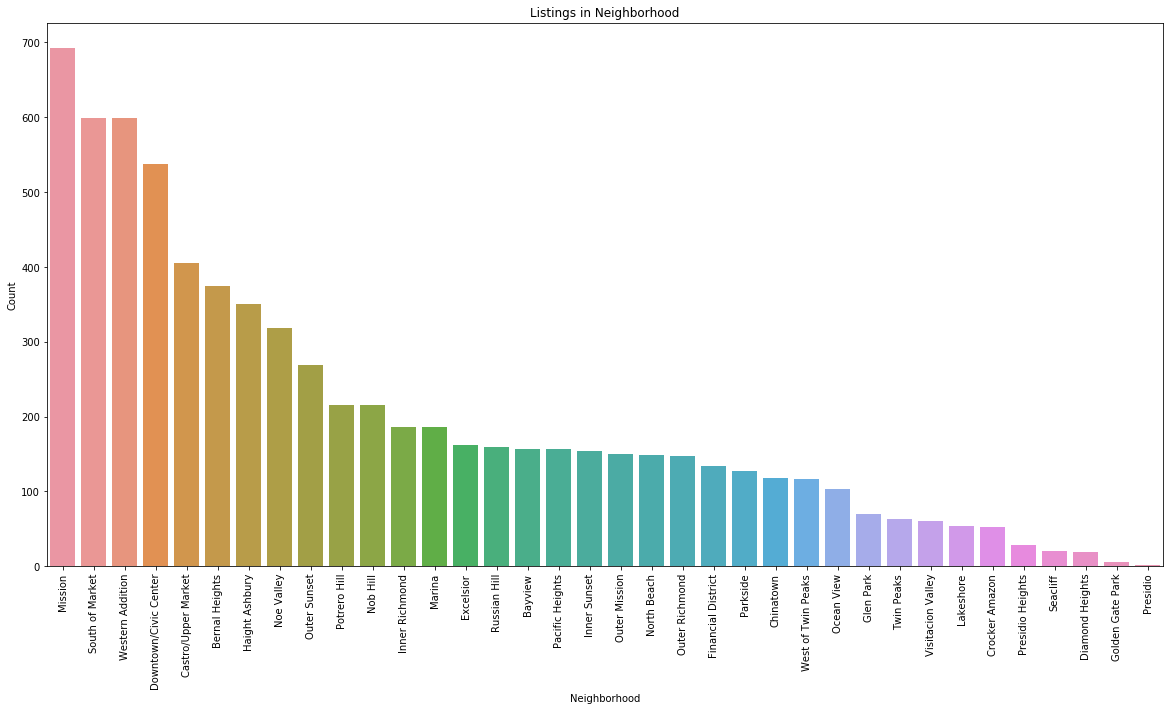

In [47]:
#Listings by neighborhoods
count, ax = plt.subplots(figsize = (20,10))
ax = sns.countplot('neighbourhood_cleansed', data=listing_clean,
                   order=listing_clean['neighbourhood_cleansed'].value_counts().index)
ax.set_title('Listings in Neighborhood')
plt.xticks(rotation=90)
ax.set_xlabel('Neighborhood')
ax.set_ylabel('Count')

#### From the plot, top three neighborhoods with maximum number of listings are Mission, Western Addition and South of Market. Presidio has the least number of listings in Airbnb.

Text(0, 0.5, 'Count')

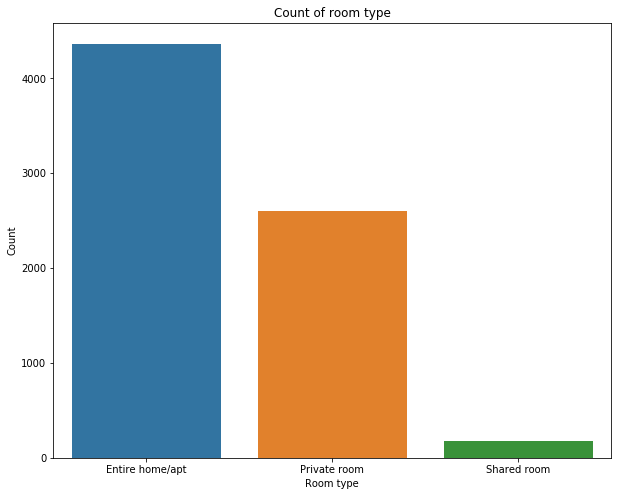

In [48]:
#Listings by room type
count, ax = plt.subplots(figsize=(10,8))
ax = sns.countplot('room_type', data=listing_clean)
ax.set_title('Count of room type')
ax.set_xlabel('Room type')
ax.set_ylabel('Count')

In [49]:
listing_clean['room_type'].value_counts()

Entire home/apt    4366
Private room       2606
Shared room         179
Name: room_type, dtype: int64

#### The plot above clearly shows that most of the listings (~60%) in Airbnb are for entire home/apartment, followed by private room listings (37%). Shared room listings only account for ~3% of the total listings.

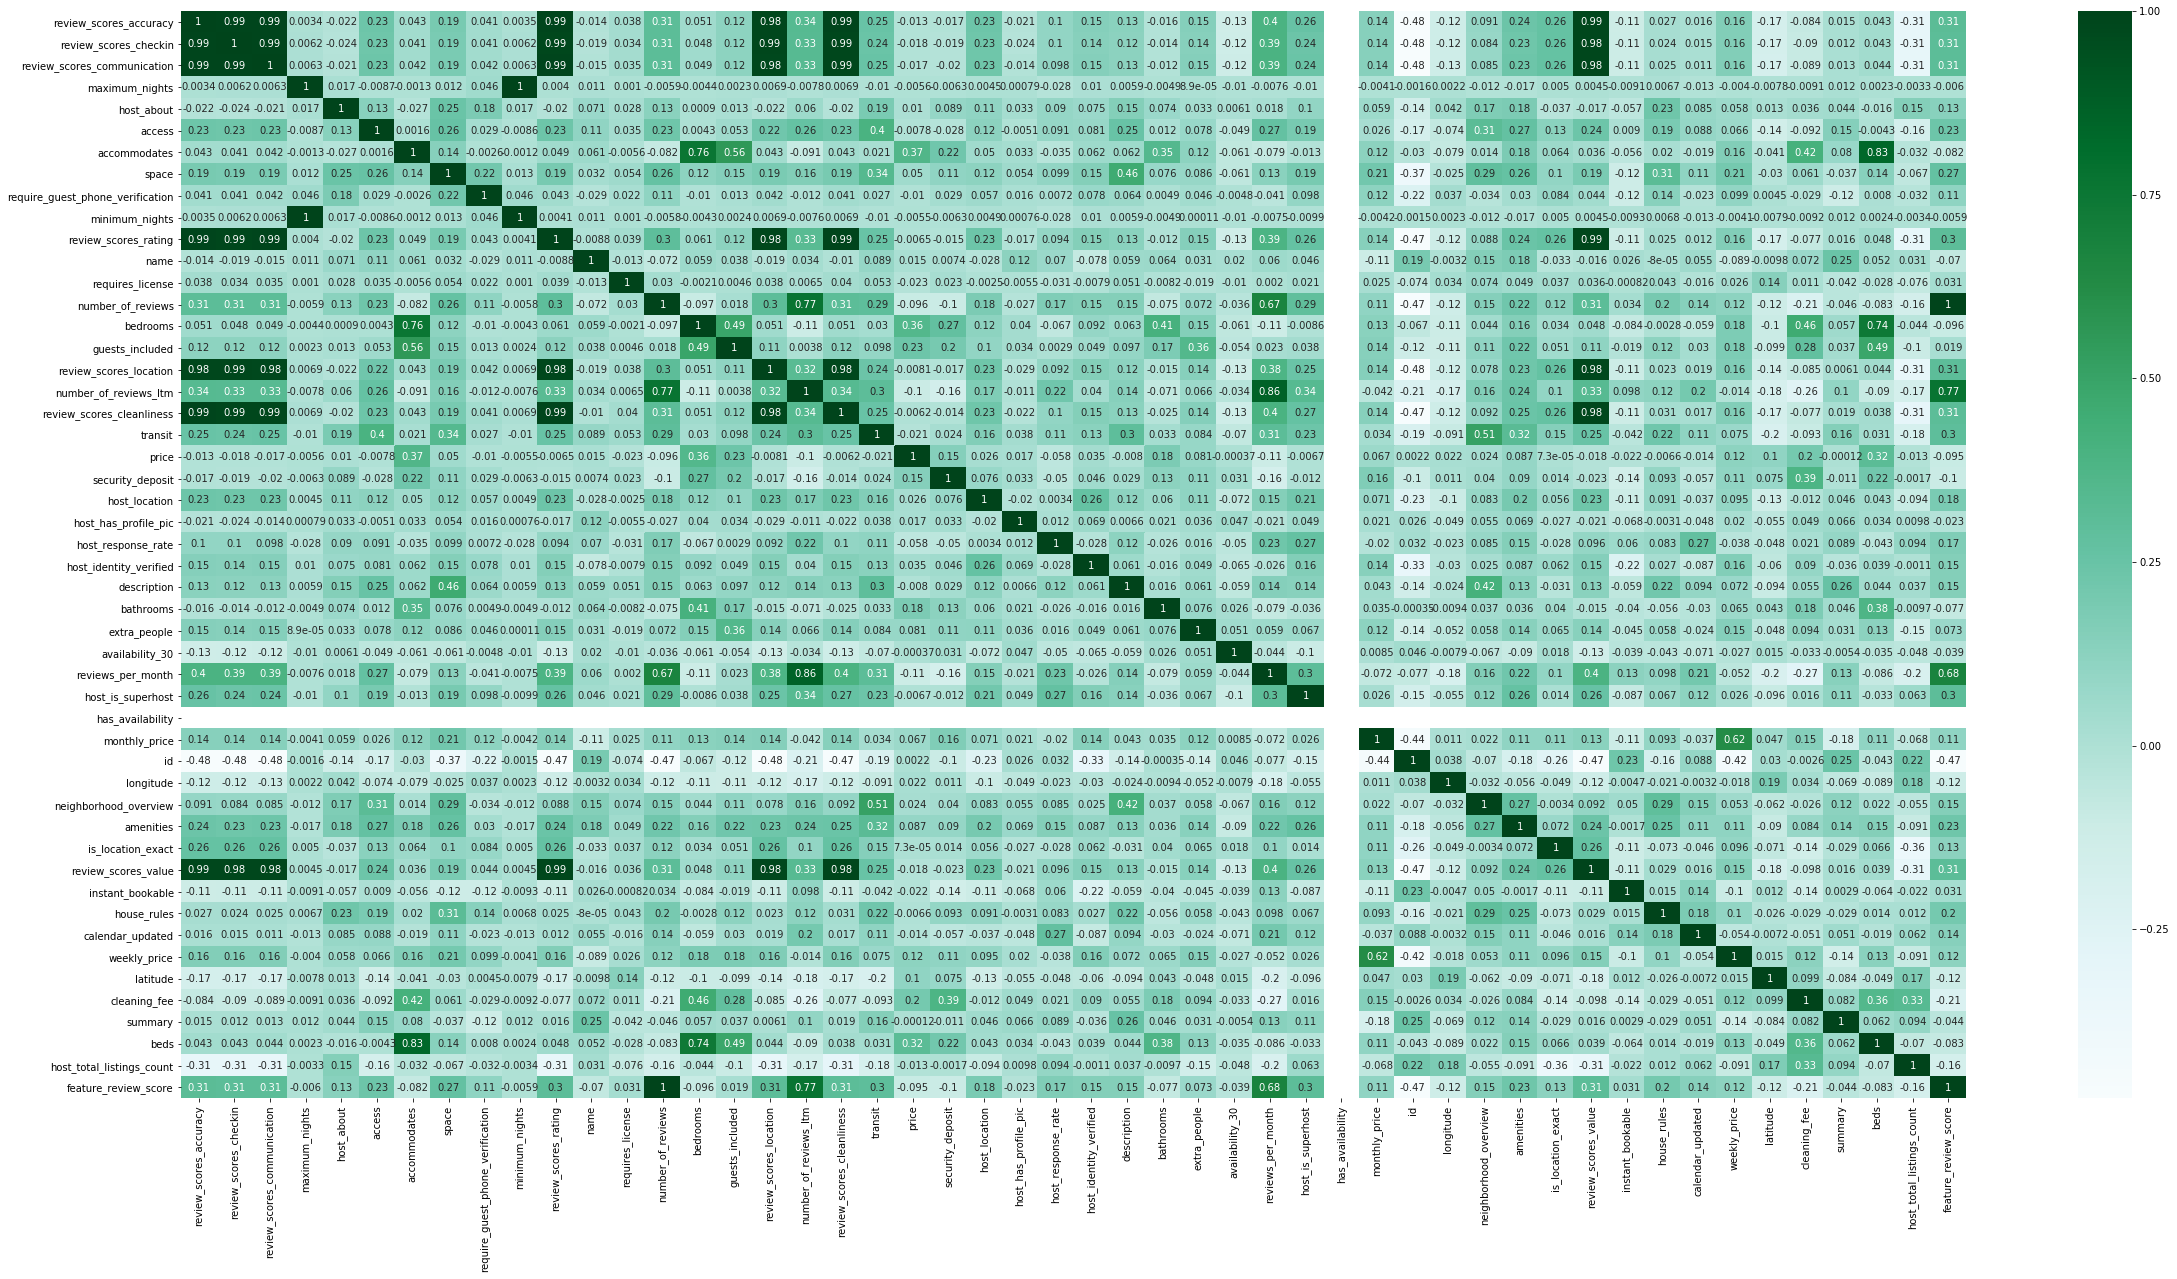

In [50]:
#Correlation plot
plt.rcParams["figure.figsize"] = "40,20"
sns.heatmap(listing_clean.corr(), annot=True, cmap='BuGn')

In [51]:
listing_clean.columns

Index(['review_scores_accuracy', 'review_scores_checkin',
       'review_scores_communication', 'maximum_nights', 'host_about', 'access',
       'accommodates', 'space', 'require_guest_phone_verification',
       'minimum_nights', 'review_scores_rating', 'host_name', 'name',
       'room_type', 'requires_license', 'host_response_time',
       'number_of_reviews', 'bedrooms', 'guests_included',
       'review_scores_location', 'host_since', 'number_of_reviews_ltm',
       'review_scores_cleanliness', 'bed_type', 'transit', 'price',
       'security_deposit', 'host_location', 'host_has_profile_pic',
       'host_response_rate', 'host_identity_verified', 'description',
       'bathrooms', 'extra_people', 'neighbourhood_cleansed',
       'availability_30', 'reviews_per_month', 'host_is_superhost',
       'cancellation_policy', 'has_availability', 'monthly_price', 'id',
       'longitude', 'neighborhood_overview', 'amenities', 'is_location_exact',
       'review_scores_value', 'instant_book

In [85]:
listing_clean['host_since'] = listing_clean['host_since'].dt.days

In [87]:
listing_clean.to_csv('Listing_clean.csv', index=False)

## Prediction for review score

#### The first problem which would like to look at is - prediction of review score given the features. We can now proceed to further filter the existing dataframe for this purpose by removing things like calender updated, name, summary which will not have an impact on review score.

In [53]:
unwanted_for_review = ['calendar_updated', 'name', 'summary', 'description','number_of_reviews_ltm','last_review',
                       'host_about', 'host_total_listings_count', 'id', 'space', 'maximum_nights', 'has_availability',
                       'host_has_profile_pic', 'availability_30', 'reviews_per_month', 'review_scores_accuracy',
                       'review_scores_communication', 'review_scores_rating', 'number_of_reviews', 'review_scores_location',
                       'review_scores_checkin', 'review_scores_cleanliness','review_scores_value' ]

In [54]:
listings_for_review = listing_clean.drop(unwanted_for_review, axis=1)
listings_for_review.head()

,access,accommodates,require_guest_phone_verification,minimum_nights,host_name,room_type,requires_license,host_response_time,bedrooms,guests_included,...,amenities,is_location_exact,instant_bookable,house_rules,property_type,weekly_price,latitude,cleaning_fee,beds,feature_review_score
0,191.0,3,0,1,Holly,Entire home/apt,1,within an hour,1.0,2,...,361,1,1,110.0,Apartment,1120.0,37.76931,100.0,2.0,17460.0
1,83.0,5,0,30,Philip And Tania,Entire home/apt,1,within a day,2.0,2,...,211,1,0,67.0,Apartment,1600.0,37.74511,100.0,3.0,10878.0
2,0.0,2,0,32,Aaron,Private room,1,within a few hours,1.0,1,...,303,1,0,88.0,Apartment,485.0,37.76669,50.0,1.0,1445.0
3,0.0,2,0,32,Aaron,Private room,1,within a few hours,1.0,1,...,227,1,0,44.0,Apartment,490.0,37.76487,50.0,1.0,744.0
4,51.0,5,1,7,Rosy,Entire home/apt,1,within an hour,2.0,2,...,150,1,0,303.0,House,0.0,37.77525,225.0,2.0,2619.0


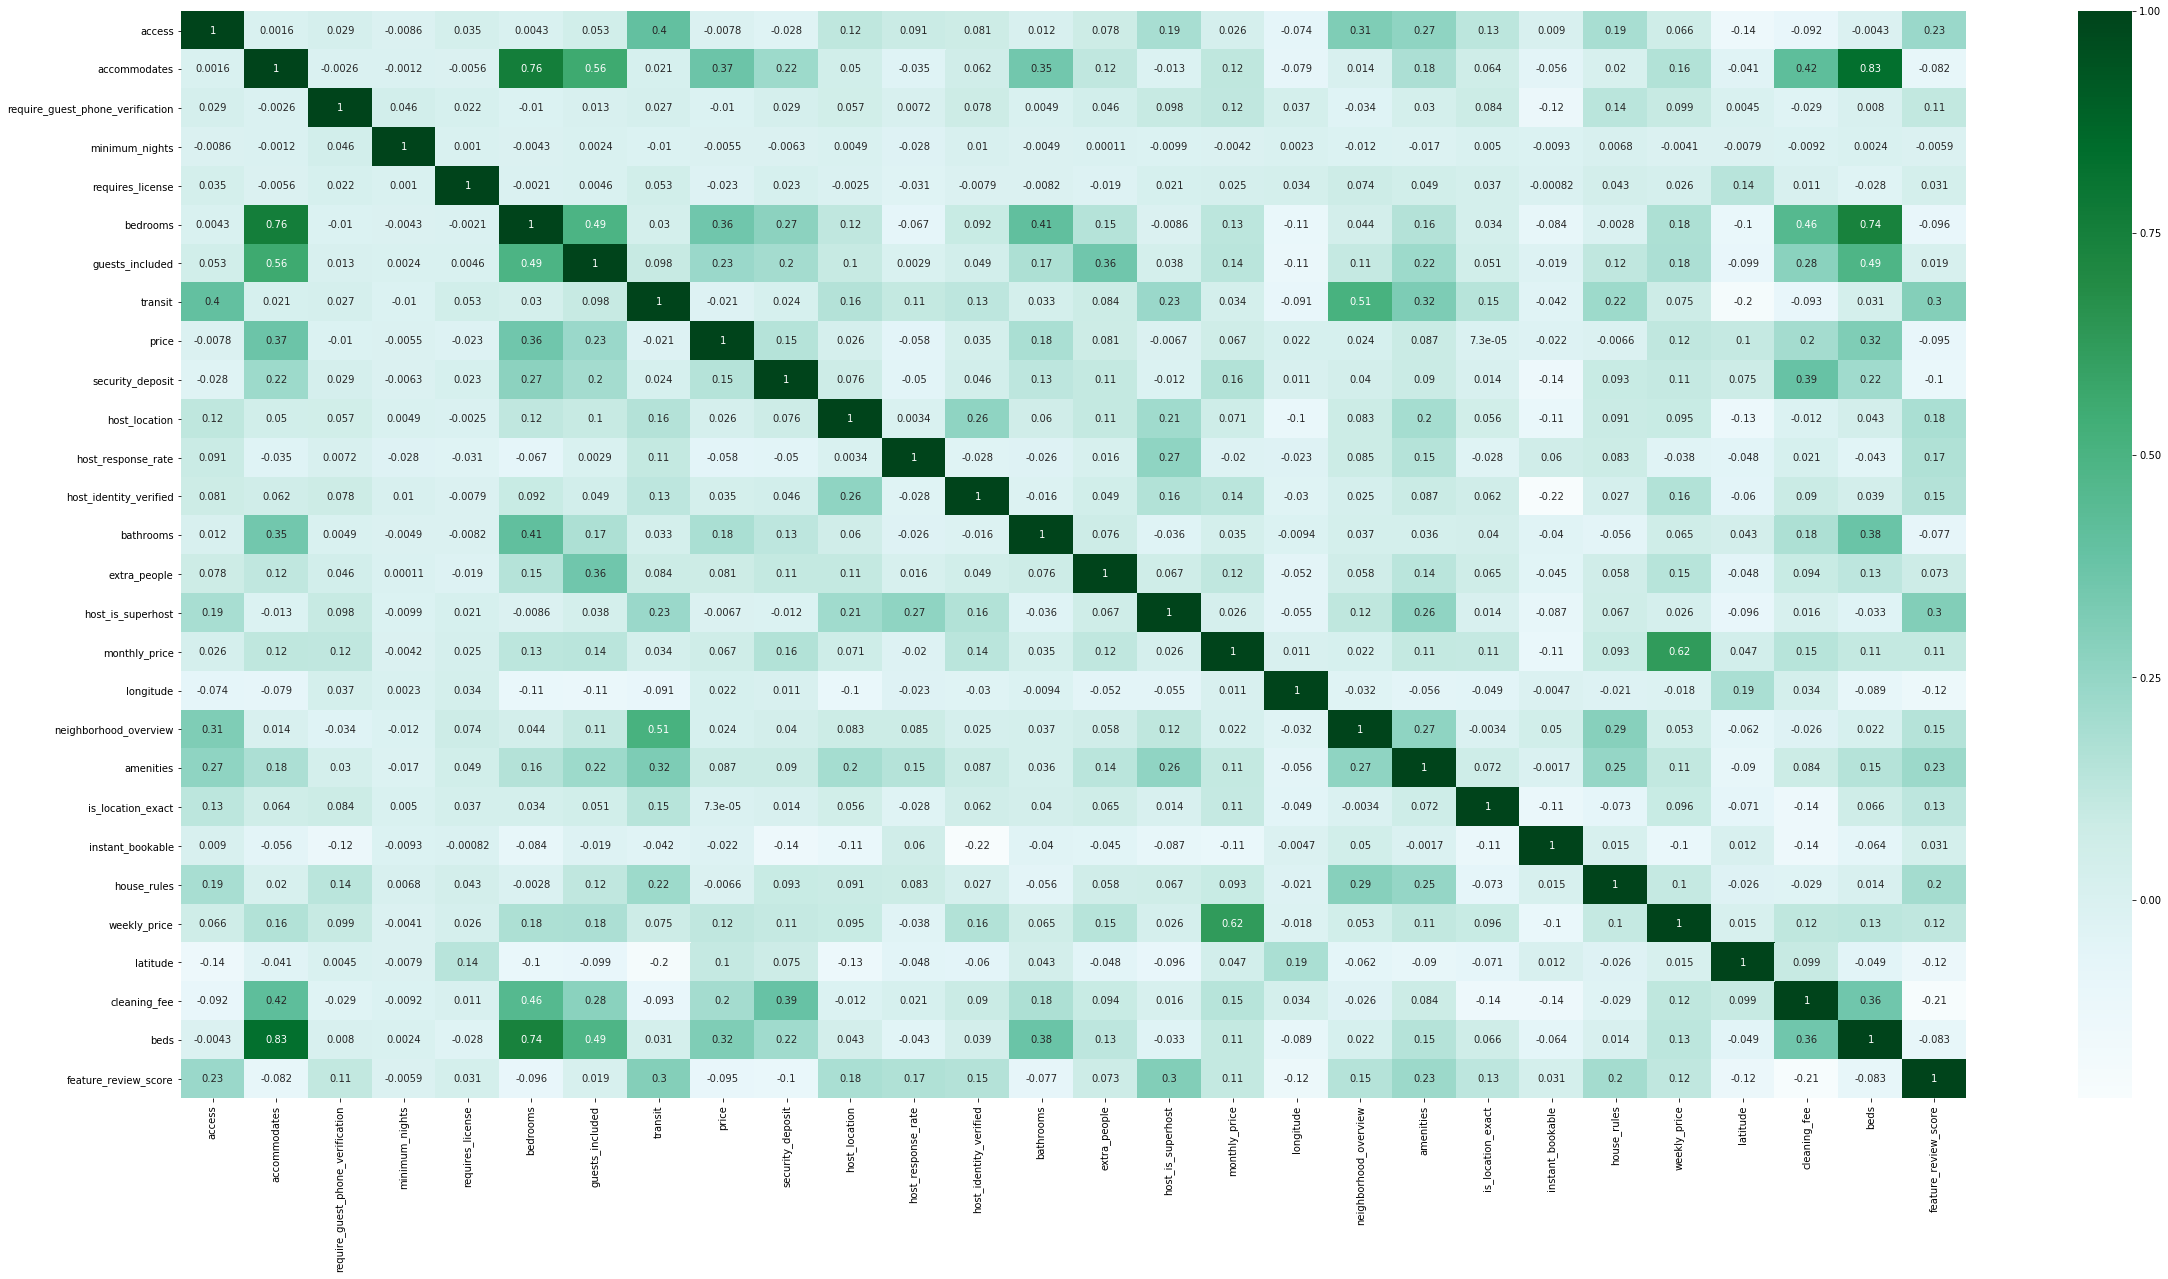

In [55]:
#Correlation plot
plt.rcParams["figure.figsize"] = "40,20"
sns.heatmap(listings_for_review.corr(), annot=True, cmap='BuGn')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35]), <a list of 36 Text xticklabel objects>)

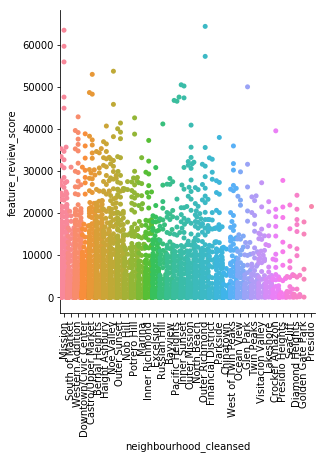

In [63]:
# remove host name
# convert latitude longitude to distance from center of the city
plt.rcParams["figure.figsize"] = "25,10"
sns.catplot('neighbourhood_cleansed', y="feature_review_score", kind='swarm',data=listings_for_review,
                   order=listing_clean['neighbourhood_cleansed'].value_counts().index)
plt.xticks(rotation=90)

## Feature Extraction and Scaling

In [56]:
# For extracting distance from Sanfranciso center to each latitude/longitude 
from geopy.geocoders import Nominatim
from geopy.distance import geodesic

# For extracting distance to the major cities -San Francisco and Los Angeles
geolocator = Nominatim(timeout=3)
location = geolocator.geocode('San Francisco')
SF_lat_long = str(location.latitude) + ',' + str(location.longitude)

In [57]:
listings_for_review['lat_long'] = listings_for_review['latitude'].astype(str) + ',' + \
listings_for_review['longitude'].astype(str)

distance = []
for location in range (listings_for_review.shape[0]):
    distance.append(round(geodesic(listings_for_review['lat_long'][location], SF_lat_long).miles,2))

listings_for_review ['distance_to_SFcenter'] = distance

In [58]:
listings_for_review['host_since'] = listings_for_review['host_since'].dt.days

In [59]:
listings_continous = listings_for_review.select_dtypes(exclude='object').drop(['latitude','longitude'], axis=1)
# Scaling the data
scaler = MinMaxScaler(feature_range=(1,2))
listings_continous_scaled = pd.DataFrame(scaler.fit_transform(listings_continous),
                                         columns = listings_continous.columns.tolist())

In [60]:
listings_objects = pd.get_dummies(listings_for_review.select_dtypes(include='object').drop(['host_name', 'lat_long'], axis=1))
pred_review, resp_review = pd.concat([listings_continous,listings_objects],axis=1).drop(['feature_review_score'], 
                                                    axis=1), listings_for_review['feature_review_score']

## Linear Regression

In [61]:
#splitting the data into train and test splits
pred_train, pred_test, resp_train, resp_test = train_test_split(pred_review, resp_review, random_state=42)

#Fit model and predict
lr = LinearRegression()
lr.fit(pred_train, resp_train)
resp_pred = lr.predict(pred_test)

#Look at the results
values = np.append(lr.intercept_, lr.coef_)
names = np.append('Intercept', pred_train.columns)
results = pd.DataFrame(values, index=names, columns=['Coef'])
print(results)
print(f'Variance score of the model is {r2_score(resp_test, resp_pred)}')
print(f'Mean squared error of the model is {mean_squared_error(resp_test, resp_pred)}')

                                                        Coef
Intercept                                       -2354.295855
access                                              1.622834
accommodates                                      205.582496
require_guest_phone_verification                 1124.234605
minimum_nights                                     -0.000050
requires_license                                   36.943292
bedrooms                                         -426.279518
guests_included                                   144.804587
host_since                                          0.737300
transit                                             2.346342
price                                              -0.874550
security_deposit                                   -0.424156
host_location                                     558.735226
host_response_rate                               2800.142087
host_identity_verified                            852.939854
bathrooms               

#### The variance score for the model is 32%, which by the looks of it isnt very impressive. But with so may predictors, we have to balance our expectations.

In [62]:
model = sm.OLS(resp_review, pred_review)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     feature_review_score   R-squared:                       0.327
Model:                              OLS   Adj. R-squared:                  0.317
Method:                   Least Squares   F-statistic:                     33.51
Date:                  Thu, 04 Apr 2019   Prob (F-statistic):               0.00
Time:                          23:17:45   Log-Likelihood:                -72004.
No. Observations:                  7151   AIC:                         1.442e+05
Df Residuals:                      7048   BIC:                         1.449e+05
Df Model:                           102                                         
Covariance Type:              nonrobust                                         
===================================================================================================================
                                                      coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------
access                                              1.3485      0.429      3.145      0.002       0.508       2.189
accommodates                                      248.9955     78.562      3.169      0.002      94.991     403.000
require_guest_phone_verification                 1139.6667    306.788      3.715      0.000     538.270    1741.063
minimum_nights                                  -5.141e-05   5.78e-05     -0.890      0.374      -0.000    6.19e-05
requires_license                                  310.7185    891.020      0.349      0.727   -1435.949    2057.386
bedrooms                                         -387.5032    138.141     -2.805      0.005    -658.302    -116.704
guests_included                                    54.2263     68.541      0.791      0.429     -80.135     188.587
host_since                                          0.7558      0.103      7.338      0.000       0.554       0.958
transit                                             2.6376      0.333      7.917      0.000       1.985       3.291
price                                              -0.8602      0.246     -3.498      0.000      -1.342      -0.378
security_deposit                                   -0.4061      0.112     -3.634      0.000      -0.625      -0.187
host_location                                     392.7678    225.247      1.744      0.081     -48.785     834.321
host_response_rate                               2928.1927   1072.963      2.729      0.006     824.862    5031.524
host_identity_verified                            934.0332    162.784      5.738      0.000     614.928    1253.138
bathrooms                                        -288.5129    106.123     -2.719      0.007    -496.546     -80.480
extra_people                                        0.9452      2.550      0.371      0.711      -4.053       5.944
host_is_superhost                                2075.6628    163.149     12.722      0.000    1755.841    2395.485
monthly_price                                       0.2167      0.045      4.763      0.000       0.128       0.306
neighborhood_overview                              -0.8162      0.285     -2.860      0.004      -1.376      -0.257
amenities                                           2.0355      0.434      4.691      0.000       1.185       2.886
is_location_exact                                 727.6278    213.764      3.404      0.001     308.585    1146.670
instant_bookable                                  982.1637    158.922      6.180      0.000     670.629    1293.698
house_rules                                         2.6512      0.237     11.165      0.000       2.186       3.117
weekly_price                                 

In [63]:
type(results.pvalues)
#results.tvalues
#print('Parameters: ', results.params)
ols_results = pd.concat([results.params,results.pvalues,results.tvalues], axis=1)
ols_results.columns = ['Coefs','pvalues','tvalues']
ols_results.abs()[ols_results.pvalues < 1e-03].sort_values(by='pvalues', ascending=True)

,Coefs,pvalues,tvalues
host_is_superhost,2075.662765,1.120582e-36,12.722469
house_rules,2.651168,1.053626e-28,11.164874
cleaning_fee,12.178454,1.183030e-27,10.944085
transit,2.637593,2.800276e-15,7.917298
host_since,0.755833,2.408459e-13,7.338129
property_type_Guest suite,4020.378399,1.624972e-10,6.402663
instant_bookable,982.163748,6.760155e-10,6.180169
host_identity_verified,934.033192,9.984228e-09,5.737884
monthly_price,0.216705,1.946831e-06,4.762861
amenities,2.035461,2.763933e-06,4.691448


## Random Forest

In [64]:
#Using Random forest regressor
rforest = RandomForestRegressor(random_state=42, n_jobs=-1)

#Performing a randomized search for finding best parameters
param_dist = {'n_estimators': range(500,1500,500),
              'max_depth': range(1,8,2),
              'max_features': range(1,20,2),
              'min_samples_split': range(500,2000,500)
             }
rforest_cv = RandomizedSearchCV(rforest, param_distributions=param_dist, cv=10, scoring='explained_variance')

In [65]:
rforest_cv.fit(pred_train, resp_train)
rforest_cv

RandomizedSearchCV(cv=10, error_score='raise-deprecating',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=-1,
           oob_score=False, random_state=42, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=None,
          param_distributions={'n_estimators': range(500, 1500, 500), 'max_depth': range(1, 8, 2), 'max_features': range(1, 20, 2), 'min_samples_split': range(500, 2000, 500)},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='explained_variance',
          verbose=0)

In [66]:
resp_pred = rforest_cv.predict(pred_test)
print(rforest_cv.score(pred_test, resp_test))
best_pred_new = rforest_cv.best_estimator_
best_pred_new

0.2884166621390396


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features=11, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=500, min_weight_fraction_leaf=0.0,
           n_estimators=500, n_jobs=-1, oob_score=False, random_state=42,
           verbose=0, warm_start=False)

Text(0, 0.5, 'Feature Importance')

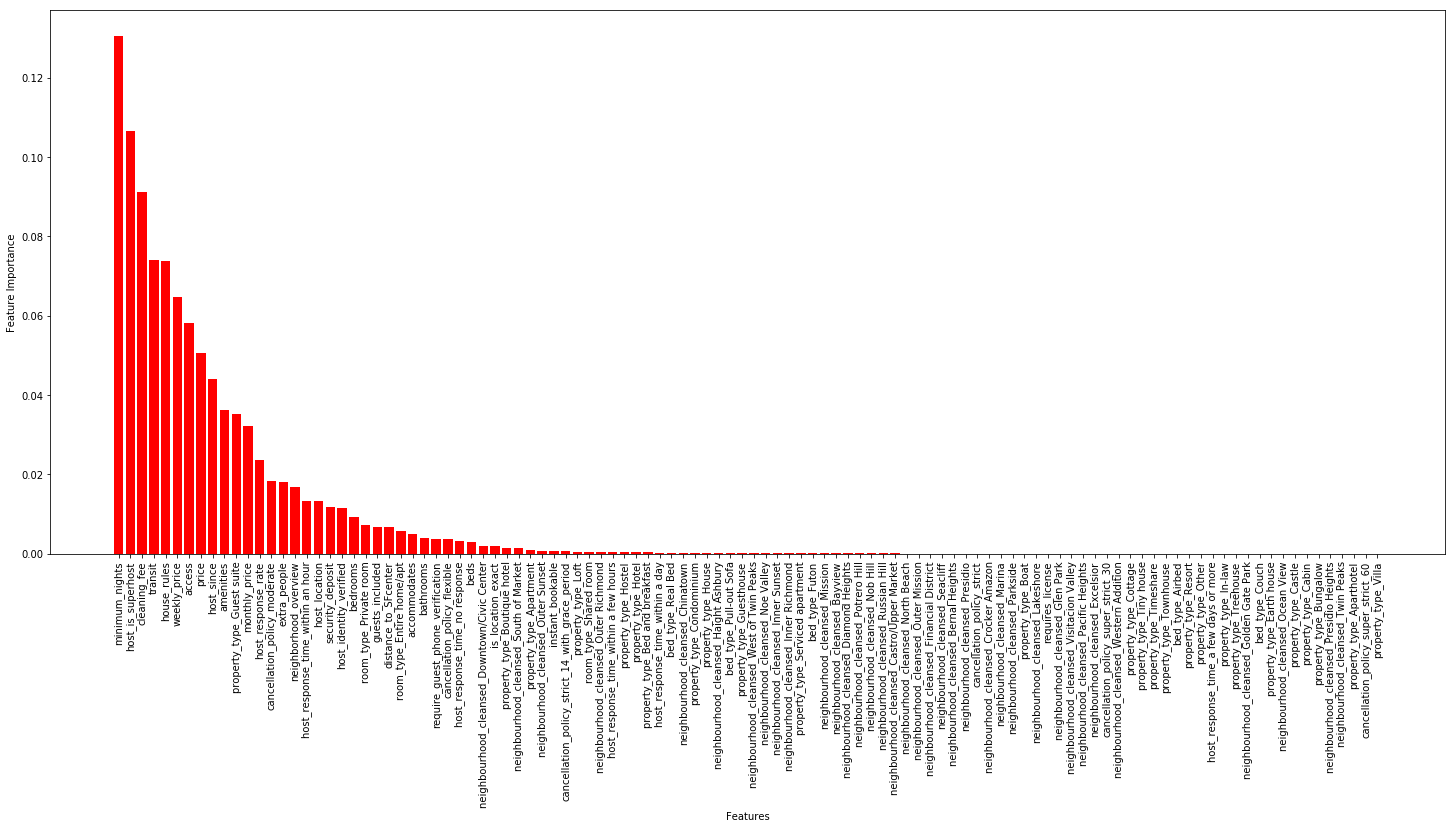

In [67]:
feature_importances = pd.DataFrame(best_pred_new.feature_importances_ ,
                                   index = pred_train.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)
plt.rcParams["figure.figsize"] = "25,10"
plt.bar(feature_importances.index, feature_importances.importance, color = "red")
plt.xlabel("Features")
plt.xticks(rotation=90)
plt.ylabel("Feature Importance")

#### Random forests variance score is only 28%, 6% less compared to linear regression.

## XGBoost 

In [68]:
# Using XG boosting
xgb = XGBRegressor(n_estimators=1000, learning_rate=0.01)
param_dist = {'n_estimators': [1000,1500,2000],
              'learning_rate': [0.01,0.001],
              'max_depth': [2,3,4]
             }
xgb_cv = RandomizedSearchCV(xgb, param_distributions=param_dist, cv=10)

In [69]:
xgb_cv.fit(pred_train, resp_train)
res_pred = xgb_cv.predict(pred_test)

In [70]:
print(f'Variance score for Gradient boost Algorithm is: {xgb_cv.score(pred_test, resp_test)}')
print(f'MSE : {mean_squared_error(resp_test,res_pred)}')
rough_errors = np.round(np.sqrt(mean_squared_error(resp_test,res_pred)),2)
print(f'Model makes rough miscalculations of about {rough_errors}')

Variance score for Gradient boost Algorithm is: 0.5388349957426973
MSE : 22509362.51449057
Model makes rough miscalculations of about 4744.4


#### XG Boost Algorithm gave us the best variance score of 54% compared to 32% of linear regression and 28% of Random Forests.

In [71]:
xgb_cv.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.01, max_delta_step=0, max_depth=4,
       min_child_weight=1, missing=None, n_estimators=2000, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

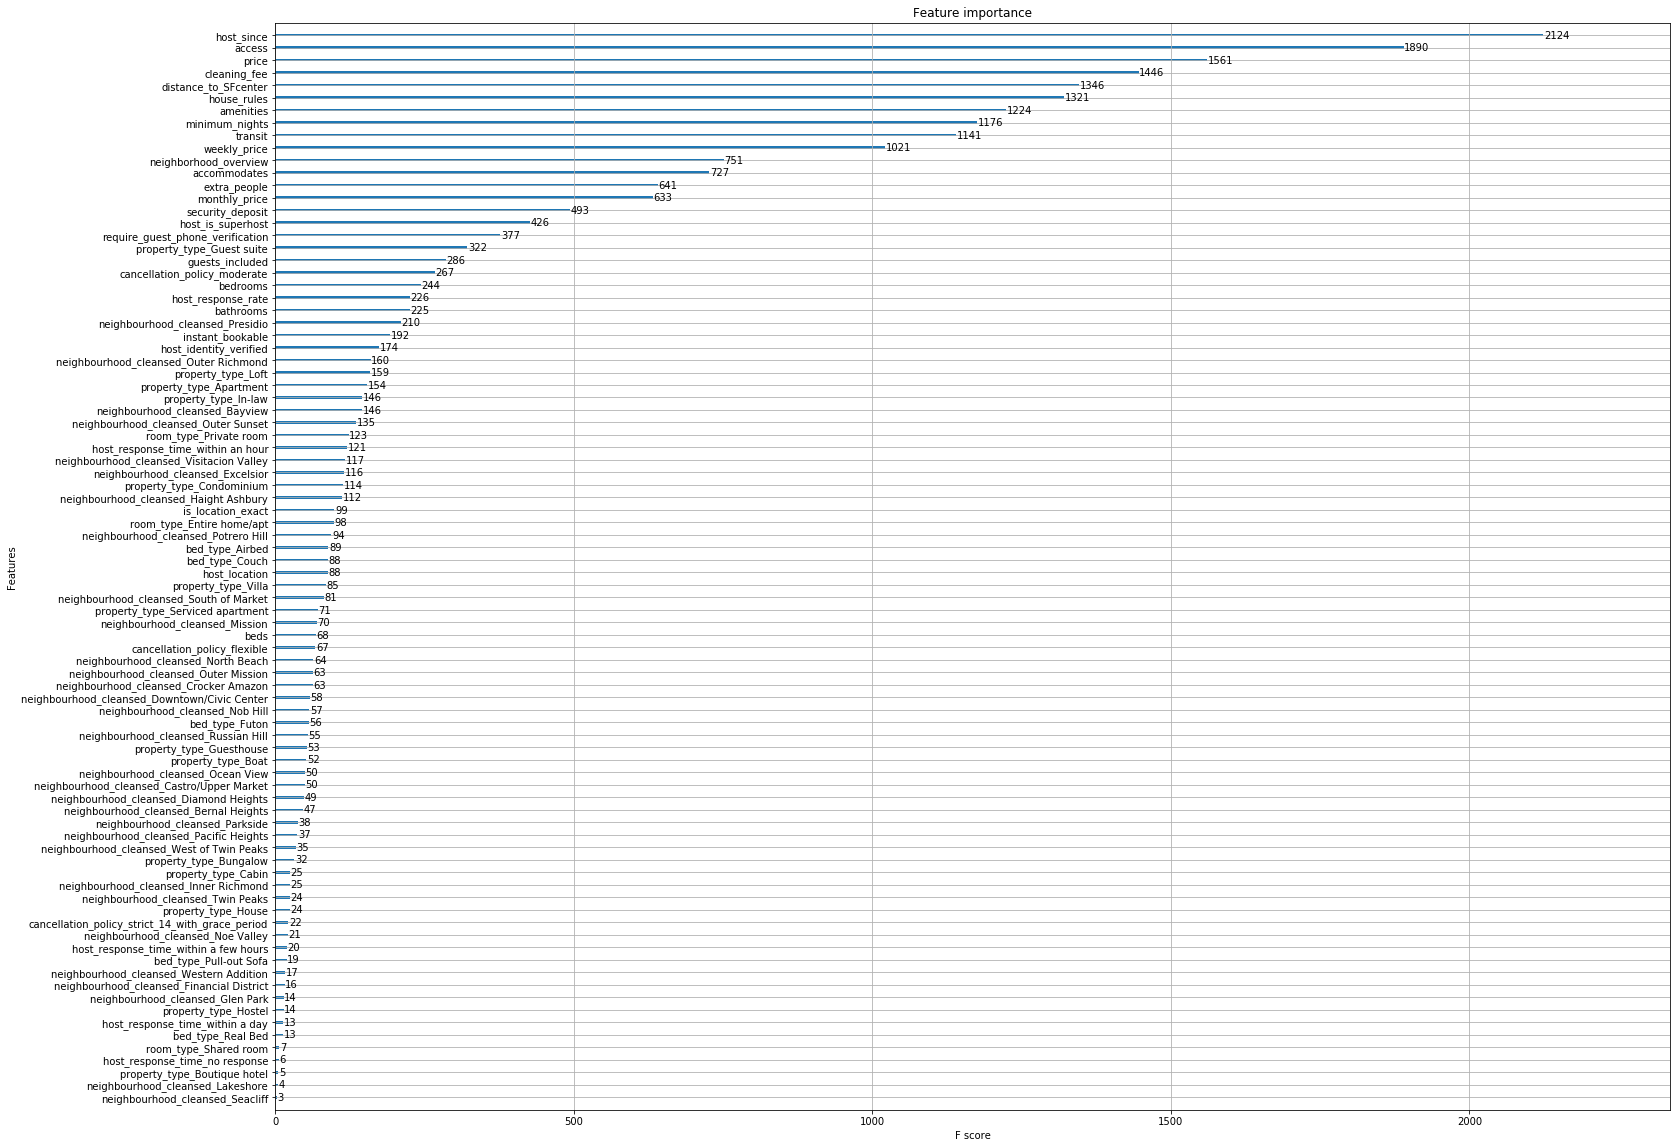

In [72]:
from xgboost import plot_importance
plt.rcParams["figure.figsize"] = "25,20"
plot_importance(xgb_cv.best_estimator_)

Wall time: 6.68 s


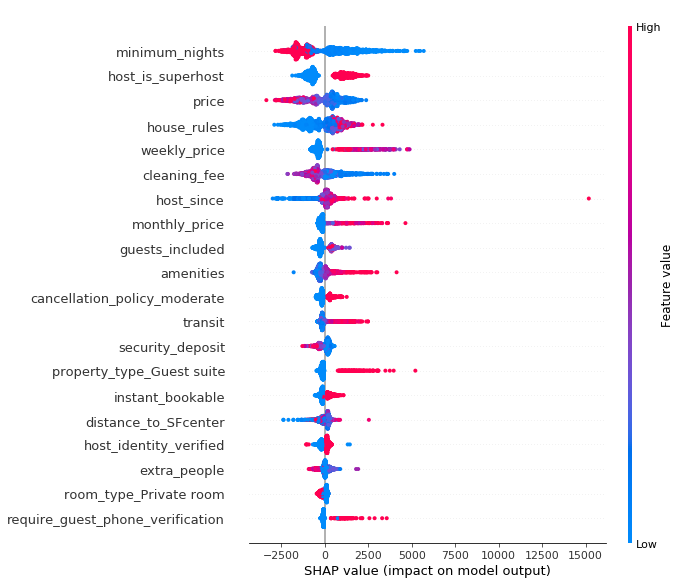

In [88]:
import shap
%time shap_values = shap.TreeExplainer(xgb_cv.best_estimator_).shap_values(pred_test)
shap.summary_plot(shap_values, pred_test)

### The results from XGBoost tell us that the most import predictors or the factors that influence good ratings - or the recommendations for hosts to get a better rating are:

### Minimum number of nights is low - This is interesting to note!
### Host is super host - Try to be a superhost.
### Low Price - Keep the price competitive (No surprise here!)
### Better house rules - Having more house rules may ultimately impact the cleanliness and better relationship with the guest.
### Low cleaning fee
### Being a host since a long time

### Other aspects like being able to accomodate extra people, more transit options, host response within an hour, more amenities, moderate cancellation policy seem to impact high review scores